In [14]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import sparapy as sp
import sparapy.geometry as geo
from sparapy.radiosity import DirectionalRadiosity
from sparapy.radiosity_fast import DRadiosityFast
import cProfile
import pyfar as pf
import sofar as sf
import os
import tqdm
from datetime import datetime
import numpy as np
import tracemalloc

sample_walls = sp.testing.shoebox_room_stub(1, 1, 1)

In [16]:
gaussian = pf.samplings.sph_gaussian(sh_order=1)
gaussian = gaussian[gaussian.z>0]
sources = gaussian.copy()
receivers = gaussian.copy()
frequencies = pf.dsp.filter.fractional_octave_frequencies(
    1, (100, 1000))[0]
data = np.ones((sources.csize, receivers.csize, frequencies.size))
data = pf.FrequencyData(data, frequencies)
sofa = sf.Sofa('GeneralTF')
sofa.Data_Real = data.freq
sofa.Data_Imag = np.zeros_like(sofa.Data_Real)
sofa.N = data.frequencies
sofa.SourcePosition = sources.cartesian
sofa.ReceiverPosition = pf.rad2deg(receivers.spherical_elevation)
sofa_path = os.path.join(os.getcwd(), 'test.sofa')
sf.write_sofa(sofa_path, sofa)


c:\Users\jotag\Documents\dev\sparapy\.conda\Lib\site-packages\pyfar\samplings\samplings.py:300: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.gaussian.'
  warnings.warn((
c:\Users\jotag\Documents\dev\sparapy\.conda\Lib\site-packages\pyfar\classes\coordinates.py:234: PyfarDeprecationWarning: 'This function will be changed in pyfar 0.8.0 to init(x, y, z).'
  warnings.warn((
c:\Users\jotag\Documents\dev\sparapy\.conda\Lib\site-packages\pyfar\classes\coordinates.py:1050: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.SamplingSphere.'
  warnings.warn((
c:\Users\jotag\Documents\dev\sparapy\.conda\Lib\site-packages\pyfar\classes\coordinates.py:264: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.SamplingSphere.'
  warnings.warn((


In [17]:
# run one time, to get complied
radios = DRadiosityFast.from_polygon(sample_walls,1.)

radios.set_wall_scattering(
    wall_indexes=np.arange(6), scattering=data, sources=sources, receivers=receivers)
radios.set_air_attenuation(
    pf.FrequencyData(np.zeros_like(data.frequencies), data.frequencies))
radios.set_wall_absorption(
    np.arange(6),
    pf.FrequencyData(np.zeros_like(data.frequencies), data.frequencies))

for method in ['kang','universal']:
    radios.bake_geometry(ff_method=method)

for algo in ['queue','recursive']:
    radios.init_source_energy([0.5, 0.5, 0.5],algorithm=algo)
    histogram = radios.calculate_energy_exchange_receiver(
        [0.5, 0.5, 0.5], 343, 1e-3, .01, algorithm=algo,
        max_time=0.011,threshold=0.01)


C:\Users\jotag\AppData\Local\Temp\ipykernel_12284\434305726.py:4: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  radios.set_wall_scattering(


In [18]:
## settings
max_order_k = 10000000 
energy_threshold = 1e-6
methods = ['queue','recursive']

repeat = 2

ir_len=0.01
ir_res=0.00001

n_max = 2
repeat = 2

#####################################################################

steps_names = [
    'create patches', 'init energy', 'form factor',
    'energy exchange'
    ]

steps = len(steps_names)
runtime = dict({
                "queue": np.zeros((steps, n_max, repeat)), 
                "recursive": np.zeros((steps, n_max, repeat))
                })
mem_consumption = dict({
                "queue": np.zeros((steps, n_max, repeat)), 
                "recursive": np.zeros((steps, n_max, repeat))
                })
hist = dict({
            "queue":np.ndarray,
            "recursive":np.ndarray,
})

number_of_patches = np.zeros((n_max))

In [19]:
# ACTUAL RUNS
for method in methods:

    for i in range(n_max):
        max_size = 1/(2**i)

        print(f'{datetime.now()} run({i+1}/{n_max}): {max_size}')


        # run queue two times
        for j in range(repeat):

            print(f'    > rep({j+1}/{repeat})  ', end="")

            start_loop = datetime.now()
            # create patches and add material
            tracemalloc.start()
            start = datetime.now()
            radiosity = DRadiosityFast.from_polygon(sample_walls, max_size)

            radiosity.set_wall_scattering(
                np.arange(6), data, sources, receivers)
            radiosity.set_air_attenuation(
                pf.FrequencyData(np.zeros_like(data.frequencies), data.frequencies))
            radiosity.set_wall_absorption(
                np.arange(6),
                pf.FrequencyData(np.zeros_like(data.frequencies), data.frequencies))
            delta = (datetime.now() - start)
            mem_consumption[method][0, i, j] = tracemalloc.get_traced_memory()[1] # get peak memory
            tracemalloc.stop()
            runtime[method][0, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat

            # form factor
            tracemalloc.start()
            start = datetime.now()
            radiosity.bake_geometry()
            delta = (datetime.now() - start)
            mem_consumption[method][2, i, j] = tracemalloc.get_traced_memory()[1] # get peak memory
            tracemalloc.stop()
            runtime[method][2, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat

            # set energy
            tracemalloc.start()
            start = datetime.now()
            radiosity.init_source_energy([0.5, 0.5, 0.5], algorithm=method)
            delta = (datetime.now() - start)
            mem_consumption[method][1, i, j] = tracemalloc.get_traced_memory()[1] # get peak memory
            tracemalloc.stop()
            runtime[method][1, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat

            # energy exchange
            tracemalloc.start()
            start = datetime.now()
            hist[method] = radiosity.calculate_energy_exchange_receiver(
                [0.5, 0.5, 0.5], 343, ir_res, ir_len, algorithm=method, threshold=energy_threshold,
                max_time=0.011)
            delta = (datetime.now() - start)
            mem_consumption[method][3, i, j] = tracemalloc.get_traced_memory()[1] # get peak memory
            tracemalloc.stop()
            runtime[method][3, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat

            number_of_patches[i] = radiosity.n_patches
            delta = (datetime.now() - start_loop)
            delta_seconds = (delta.seconds*1e6 + delta.microseconds)*1e-6
            print(f' -> took {delta_seconds} seconds')


C:\Users\jotag\AppData\Local\Temp\ipykernel_12284\1551435108.py:21: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  radiosity.set_wall_scattering(


2024-07-05 13:41:20.371973 run(1/2): 1.0
    > rep(1/2)   -> took 622.638698 seconds
    > rep(2/2)   -> took 645.440068 seconds
2024-07-05 14:02:28.450739 run(2/2): 0.5
    > rep(1/2)   -> took 419.608591 seconds
    > rep(2/2)   -> took 382.69320799999997 seconds
2024-07-05 14:15:50.753538 run(1/2): 1.0
    > rep(1/2)   -> took 0.041645 seconds
    > rep(2/2)   -> took 0.042584 seconds
2024-07-05 14:15:50.837767 run(2/2): 0.5
    > rep(1/2)   -> took 1.54182 seconds
    > rep(2/2)   -> took 1.541312 seconds


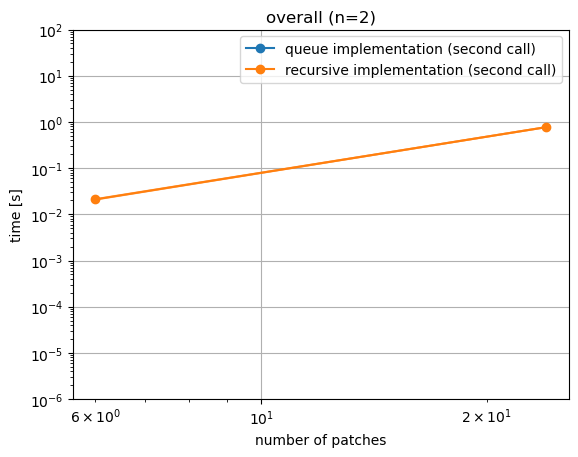

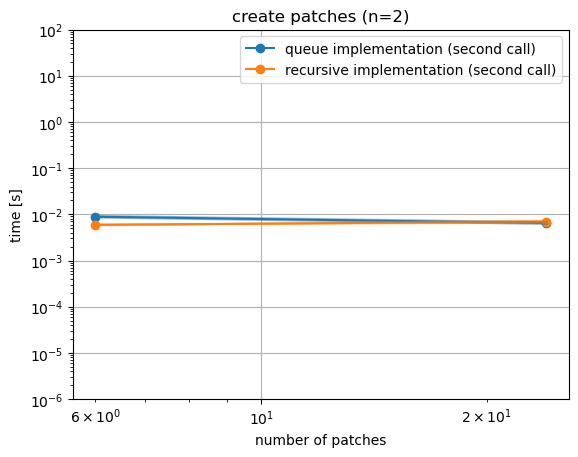

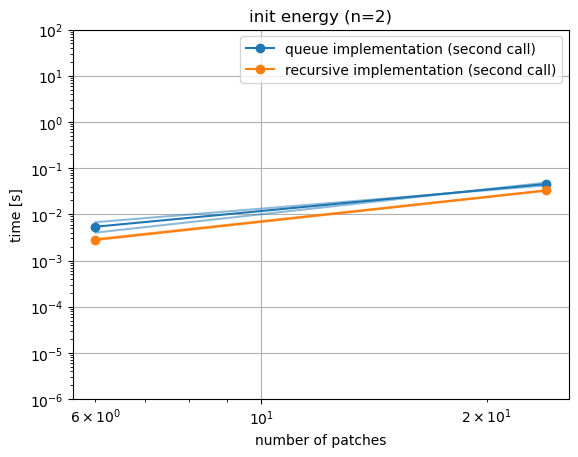

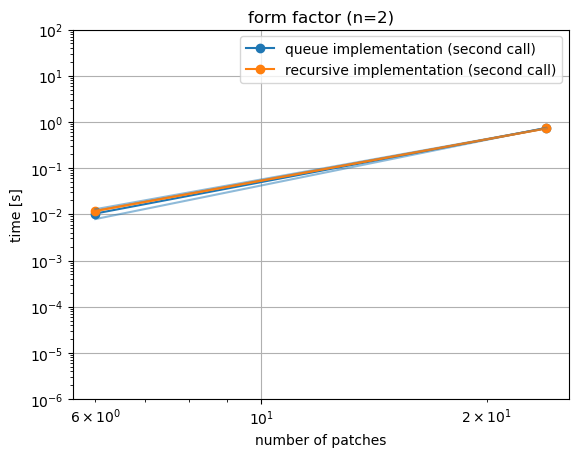

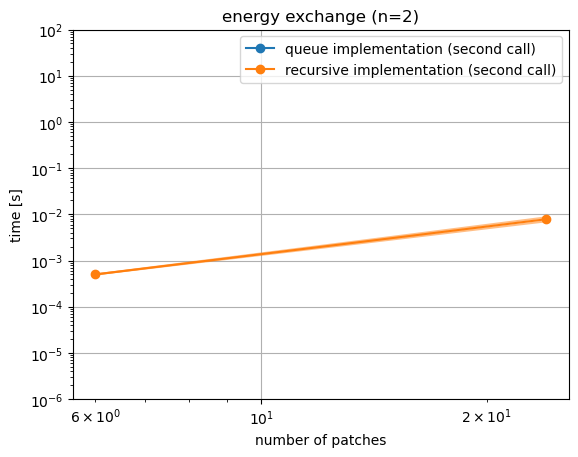

In [20]:
import matplotlib.pyplot as plt

# plot time to compute
plt.figure()
ax = plt.gca()
ax.semilogy(
    number_of_patches, np.mean(np.sum(runtime["queue"], axis=0)*1e-6, axis=-1),
    label='queue implementation (second call)', marker='o')
ax.semilogy(
    number_of_patches, np.mean(np.sum(runtime["recursive"], axis=0)*1e-6, axis=-1),
    label='recursive implementation (second call)', marker='o')
ax.semilogy(
    number_of_patches, np.sum(runtime["queue"], axis=0)*1e-6, color='C0', alpha=0.5)
ax.semilogy(
    number_of_patches, np.sum(runtime["recursive"], axis=0)*1e-6, color='C1', alpha=0.5)
ax.grid()
ax.set_xscale('log')
ax.set_xlabel('number of patches')
ax.set_ylabel('time [s]')
ax.set_title(f'overall (n={repeat})')
ax.set_ylim([1e-6, 1e2])
plt.legend()

for i in range(steps):
    plt.figure()
    ax = plt.gca()

    ax.semilogy(
        number_of_patches, np.mean(runtime["queue"][i]*1e-6, axis=-1),
        label='queue implementation (second call)', marker='o')
    ax.semilogy(
        number_of_patches, np.mean(runtime["recursive"][i]*1e-6, axis=-1),
        label='recursive implementation (second call)', marker='o')
    ax.semilogy(
        number_of_patches, runtime["queue"][i]*1e-6, color='C0', alpha=0.5)
    ax.semilogy(
        number_of_patches,  runtime["recursive"][i]*1e-6, color='C1', alpha=0.5)
    ax.grid()
    ax.set_xscale('log')
    ax.set_xlabel('number of patches')
    ax.set_ylabel('time [s]')
    ax.set_title(f'{steps_names[i]} (n={repeat})')
    ax.set_ylim([1e-6, 1e2])
    plt.legend()

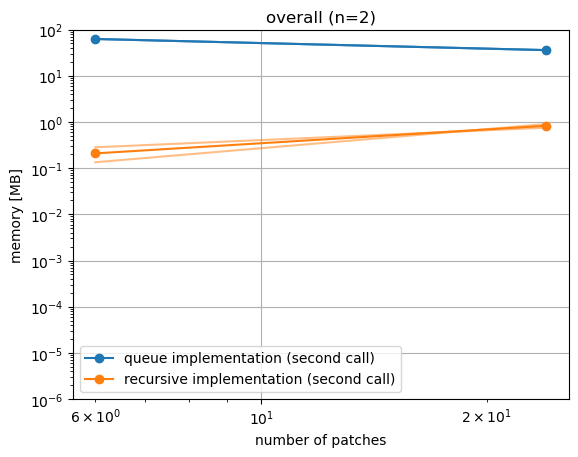

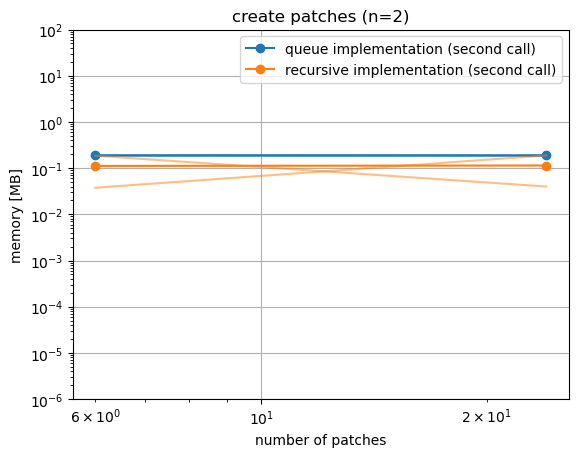

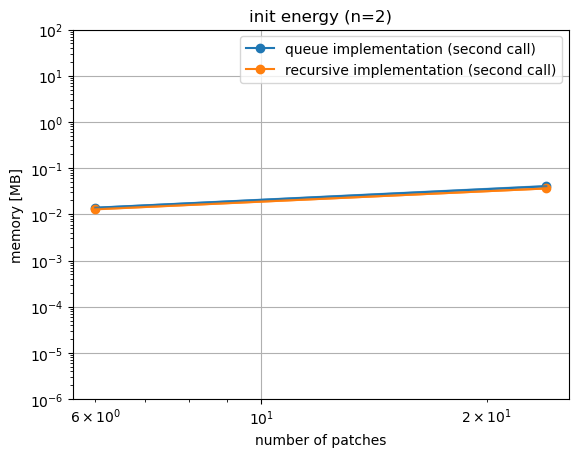

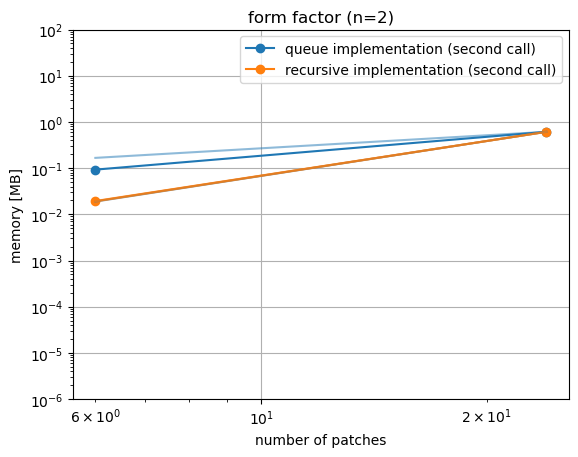

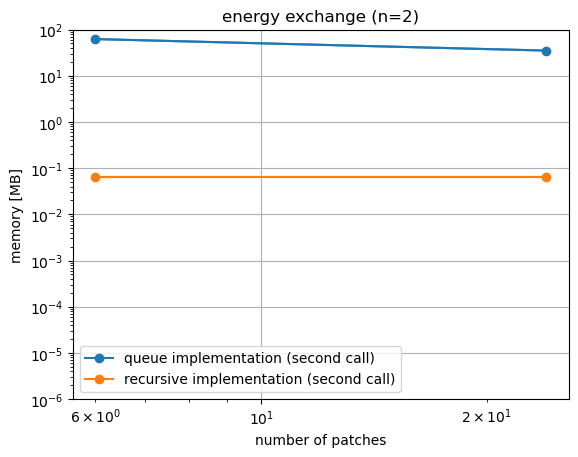

In [21]:
# plot memory consumption

plt.figure()
ax = plt.gca()
ax.semilogy(
    number_of_patches, np.mean(np.sum(mem_consumption["queue"], axis=0)*1e-6, axis=-1),
    label='queue implementation (second call)', marker='o')
ax.semilogy(
    number_of_patches, np.mean(np.sum(mem_consumption["recursive"], axis=0)*1e-6, axis=-1),
    label='recursive implementation (second call)', marker='o')
ax.semilogy(
    number_of_patches, np.sum(mem_consumption["queue"], axis=0)*1e-6, color='C0', alpha=0.5)
ax.semilogy(
    number_of_patches, np.sum(mem_consumption["recursive"], axis=0)*1e-6, color='C1', alpha=0.5)
ax.grid()
ax.set_xscale('log')
ax.set_xlabel('number of patches')
ax.set_ylabel('memory [MB]')
ax.set_title(f'overall (n={repeat})')
ax.set_ylim([1e-6, 1e2])
plt.legend()

for i in range(steps):
    plt.figure()
    ax = plt.gca()

    ax.semilogy(
        number_of_patches, np.mean(mem_consumption["queue"][i]*1e-6, axis=-1),
        label='queue implementation (second call)', marker='o')
    ax.semilogy(
        number_of_patches, np.mean(mem_consumption["recursive"][i]*1e-6, axis=-1),
        label='recursive implementation (second call)', marker='o')
    ax.semilogy(
        number_of_patches, mem_consumption["queue"][i]*1e-6, color='C0', alpha=0.5)
    ax.semilogy(
        number_of_patches, mem_consumption["recursive"][i]*1e-6, color='C1', alpha=0.5)
    ax.grid()
    ax.set_xscale('log')
    ax.set_xlabel('number of patches')
    ax.set_ylabel('memory [MB]')
    ax.set_title(f'{steps_names[i]} (n={repeat})')
    ax.set_ylim([1e-6, 1e2])
    plt.legend()

C:\Users\jotag\AppData\Local\Temp\ipykernel_12284\2747266709.py:8: RuntimeWarning: divide by zero encountered in log10
  np.abs(np.log10(hist["queue"][freqband,:]) - np.log10(hist["recursive"][freqband,:]))* 10, 'o-')
C:\Users\jotag\AppData\Local\Temp\ipykernel_12284\2747266709.py:8: RuntimeWarning: invalid value encountered in subtract
  np.abs(np.log10(hist["queue"][freqband,:]) - np.log10(hist["recursive"][freqband,:]))* 10, 'o-')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


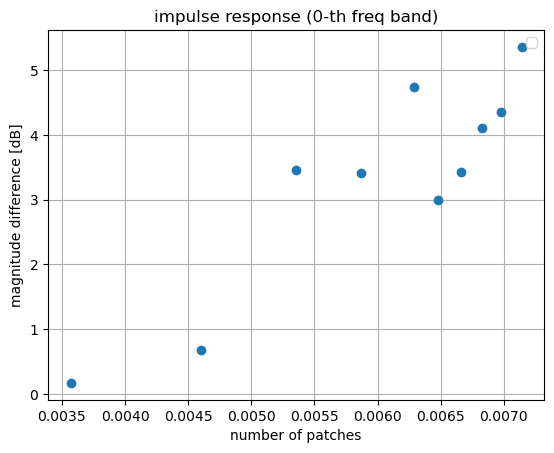

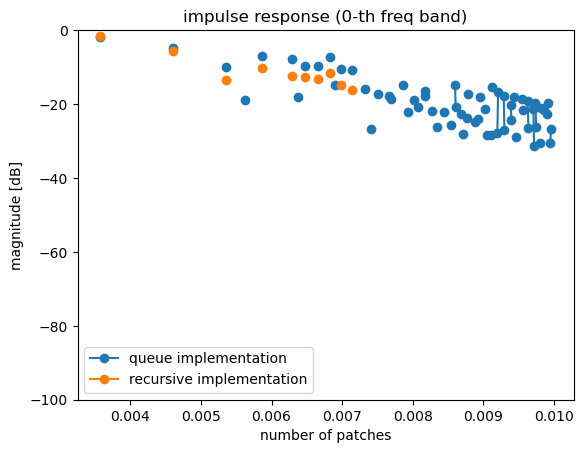

In [22]:
# plot impulse response

for freqband in range(1):#hist["queue"].shape[0]):
    plt.figure()
    ax = plt.gca()

    ax.plot(np.arange(0,ir_len-ir_res,ir_res),
            np.abs(np.log10(hist["queue"][freqband,:]) - np.log10(hist["recursive"][freqband,:]))* 10, 'o-')

    ax.grid()
    ax.set_xlabel('number of patches')
    ax.set_ylabel('magnitude difference [dB]')
    ax.set_title(f'impulse response ({freqband}-th freq band)')

    plt.legend()

    plt.figure()
    ax = plt.gca()

    for i,method in enumerate(methods):

        hist[method][hist[method]==0] = float('nan')

        ax.plot(np.arange(0,ir_len-ir_res,ir_res),
                (np.log10(hist[method][freqband,:]))* 10, 'o-',
                label=method+' implementation')

        ax.grid()
        ax.set_xlabel('number of patches')
        ax.set_ylabel('magnitude [dB]')
        ax.set_title(f'impulse response ({freqband}-th freq band)')
        ax.set_ylim([-100, 0])
        plt.legend()